# Анализ текста отзывов (на основе TF-IDF) для выявления слов, влияющих на рейтинг

In [1]:
# NLP tools
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import pymorphy2
#nltk.download("stopwords")

# conventional tools
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split #,RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #,classification_report, confusion_matrix, 

#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

## Предобработка текста: лемматизация, токенизация, выкидывание стоп-слов

In [2]:
stop_words = stopwords.words('russian')
tokenizer = RegexpTokenizer('\w+|[^\w\s]+\.') # с паттернами сложно, надо отрегулировать #'\w+|[^\w\s]+'
morph = pymorphy2.MorphAnalyzer()

In [3]:
def prepare_text(init_text, tokenizer, stop_words, morpher): # а надо ли? лучше превращать текст не в лист,
    init_text=init_text.lower() #  а в обработанный текст
    tokens=tokenizer.tokenize(init_text)
    tokens_clear=[]
    for t in tokens:
        if t in stop_words:
            continue
        tokens_clear.append(t)
    tokens_lemmatized=[]
    for t in tokens_clear:
        p = morph.parse(t)[0] #.inflect({'sing', 'NOUN'}).word
        p=p.normal_form
        tokens_lemmatized.append(p)
    final_text=' '.join(word for word in tokens_lemmatized)
    return final_text
    #return tokens_lemmatized

In [4]:
def rem_token(lst,token): # полезная функция по удалению ненужного слова из текста
    n=lst.count(token)
    if n>0:
        lst.remove(token)
        rem_token(lst,token)
    else:
        return

In [5]:
titles=["SPb", "Sochi", "UBK"]

In [6]:
SPb=pd.read_csv("SPbreviews_cleaned.csv")
Sochi=pd.read_csv("Sochireviews_cleaned.csv")
UBK=pd.read_csv("UBKreviews_cleaned.csv")

In [7]:
data_list=[SPb,Sochi,UBK]

In [8]:
data_list[1].head()

,reference,user,mark,time_delta,text,conv_date
0,https://tophotels.ru/hotel/al38931/reviews,470781,5,16,Отдыхали парой в этом отеле с 01.07.2020-08.07...,2020-07-24
1,https://tophotels.ru/hotel/al38931/reviews,2014663,4,4,Добрый день! Отдыхали мы в этом году в Сочи в ...,2020-07-21
2,https://tophotels.ru/hotel/al38931/reviews,2014160,4,1,Номера не соответствуют фото на сайте! Заказал...,2020-07-17
3,https://tophotels.ru/hotel/al38931/reviews,1849107,3,0,"Приехали мы 08.07,я с ребёнком и мама,при вход...",2020-07-15
4,https://tophotels.ru/hotel/al38931/reviews,2013519,5,30,"Отдыхали с детьми, заехали 27 июня, народу был...",2020-12-07


In [9]:
for data in data_list:
    data.text=data.text.apply(lambda x: prepare_text(x, tokenizer, stop_words, morph))

In [10]:
# saving tokenized
#for i in range(0, len(data_list)):
    #data=data_list[i]
    #title=titles[i]
    #fname=title+"reviews_tokenized.csv"
    #data.to_csv(fname,header=data.columns,index=False)

In [95]:
# reloading marks
#for i in range(0, len(titles)):
    #data=data_list[i]
    #title=titles[i]
    #fname=title+"reviews_cleaned.csv"
    #df=pd.read_csv(fname)
    #data["mark"]=df["mark"]

In [11]:
# loading tokenized
for i in range(0, len(data_list)):
    data=data_list[i]
    title=titles[i]
    fname=title+"reviews_tokenized.csv"
    data.read_csv(fname)

## Разделение на train-test и настройка TF-IDF

In [12]:
Xtrain=[]
Xtest=[]
Ytrain=[]
Ytest=[]
for data in data_list:
    Xtr, Xt, Ytr, Yt=train_test_split(data["text"],data["mark"], test_size=0.3, random_state=42)
    Xtrain.append(Xtr)
    Xtest.append(Xt)
    Ytrain.append(Ytr)
    Ytest.append(Yt)

In [13]:
TF_IDF =[]
Xtrain_tfidf=[]
Xtest_tfidf=[]
for i in range(0,len(data_list)):
    tfidf=TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.3, norm=None) #(stop_words=stop, ngram_range=(1, 2), min_df=2, max_df=0.5, norm=None)
    Xtrain_tfidf.append(tfidf.fit_transform(Xtrain[i]))
    Xtest_tfidf.append(tfidf.transform(Xtest[i]))
    TF_IDF.append(tfidf)

## Используем логистическую регрессию, чтобы оценить важность признаков

In [14]:
from sklearn.linear_model import LogisticRegressionCV

In [17]:
LogRegCV=[]
Ypred=[]
Yprob=[]
for i in range(0, len(data_list)):
    logregCV=LogisticRegressionCV(Cs=[0.005,0.01,0.03,0.05],n_jobs=-1) #solver='saga', penalty='l1' #0.0001,0.005, 0.01, 0.05, 0.1
    logregCV.fit(Xtrain_tfidf[i],Ytrain[i])
    Ypred.append(logregCV.predict(Xtest_tfidf[i]))
    Yprob.append(logregCV.predict_proba(Xtest_tfidf[i]))
    LogRegCV.append(logregCV)

## Оцениваем качество полученной модели

In [18]:
quality=pd.DataFrame(index=["Accuracy", "Precision", "Recall", "F1"])
def update_quality(qual,col_name, Ypr,Yt):
    qual[col_name]=0
    qual.loc["Accuracy", col_name]=accuracy_score(Ypr,Yt)
    qual.loc["Precision", col_name]=precision_score(Ypr,Yt,average='weighted')
    qual.loc["Recall", col_name]=recall_score(Ypr,Yt,average='macro')
    qual.loc["F1", col_name]=f1_score(Ypr,Yt,average='macro')

### Accuracy, precision, recall и F1 усредненные по классам

In [19]:
for i in range(0,len(data_list)):
    t=titles[i]
    update_quality(quality, t, Ypred[i], Ytest[i])


# # Оценка качества классификации

quality

,SPb,Sochi,UBK
Accuracy,0.670804,0.627392,0.682091
Precision,0.671976,0.624813,0.681514
Recall,0.717946,0.646972,0.709964
F1,0.684428,0.641039,0.691220


In [20]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(actual, prob_prediction)
    auc_score = roc_auc_score(actual, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

In [21]:
LogRegCV[2].C_

array([0.01, 0.01, 0.01])

### Баланс классов

In [22]:
tmp=pd.DataFrame(columns=titles)
for i in range(0,len(data_list)):
    t=titles[i]
    tmp[t]=Ytest[i].value_counts().sort_index()
tmp

,SPb,Sochi,UBK
3,359,267,194
4,705,403,465
5,789,323,508


## ROC-AUC score

In [59]:
def show_rocauc(Yprob,Ytest):
    fig, ax=plt.subplots(figsize=(10,9.6),nrows=2, ncols=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    for i in range(2,5):
        plt.subplot(2,2,i-1)
        plt.plot([0, 1], [0, 1])
        Yt=Ytest.apply(lambda x: 1 if x==i+1 else 0)
        Yp=Yprob[:,i-2]
        fpr, tpr, thresholds = roc_curve(Yt, Yp)
        auc_score = roc_auc_score(Yt, Yp)
        plt.title('\''+str(i+1)+'\''+' ROC AUC: {:.3f}'.format(auc_score))
        plt.plot(fpr, tpr, label='ROC curve ')

## С.-Пб

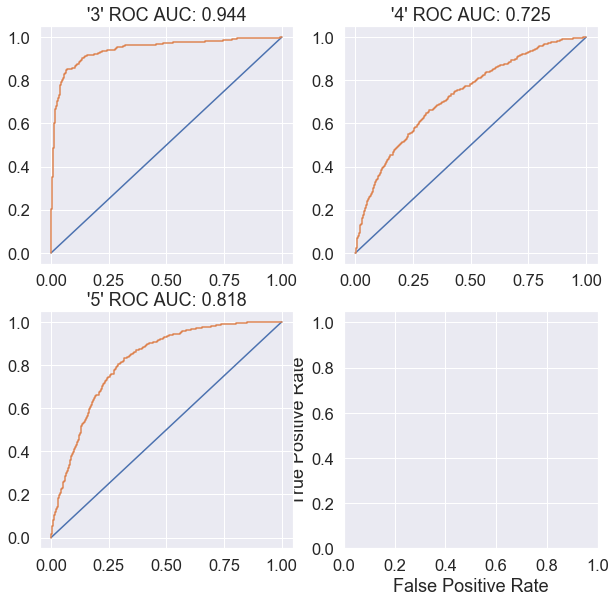

In [60]:
show_rocauc(Yprob[0], Ytest[0])

## Сочи

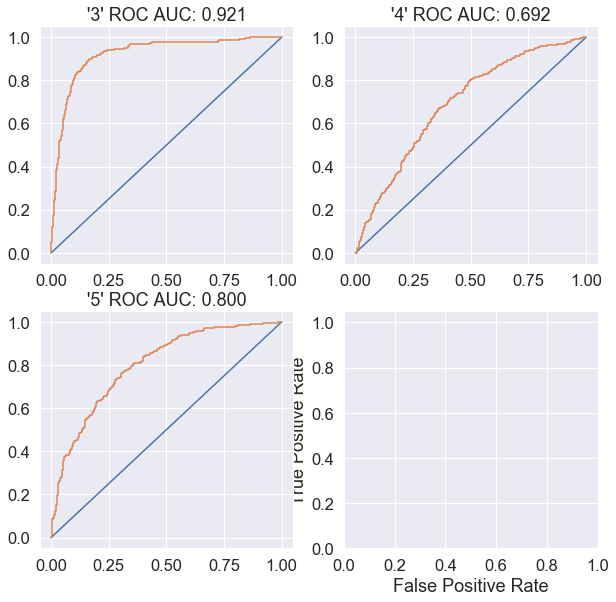

In [61]:
show_rocauc(Yprob[1], Ytest[1])

## Южный берег Крыма

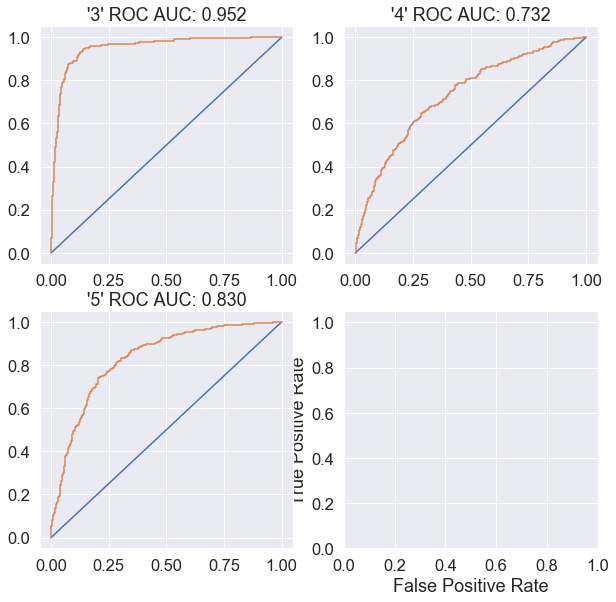

In [62]:
show_rocauc(Yprob[2], Ytest[2])

## Confusion matrix

In [63]:
from sklearn.metrics import confusion_matrix

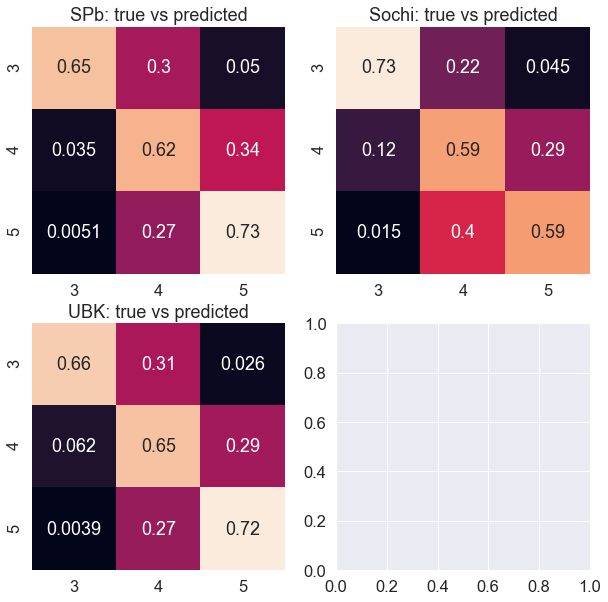

In [47]:
sns.set(font_scale=1.5)
lbls=[3,4,5]
plt.subplots(figsize=(10,10), nrows=2, ncols=2)
for i in range(0,len(titles)):
    plt.subplot(2,2,i+1)
    conf_matrix=confusion_matrix(Ytest[i], Ypred[i], normalize='true',labels=lbls) #normalize='true'
    cm=pd.DataFrame(data=conf_matrix,index=lbls,columns=lbls)
    sns.heatmap(cm,annot=True, cbar=False)
    plt.title( titles[i]+": true vs predicted")

## Слова, характерные для отзывов на "3", "4" и "5" в разных городах:

In [29]:
# # Визуализация коэффициентов, наиболее характерные слова


def plot_positive_words(coef, feature_names, positive=True, n_top_features=50):
    if positive:
        Title="Characteristic words"
        interesting_coefficients = np.argsort(coef)[-n_top_features:]
    else:
        Title="Characteristic words in negative"
        interesting_coefficients = np.argsort(coef)[:n_top_features]
    #interesting_coefficients = np.argsort(coef)[-n_top_features:]
    feature_names = np.array(feature_names)
    fn=np.reshape(feature_names[interesting_coefficients],-1)
    cf=coef[interesting_coefficients]
    wrddata=pd.DataFrame(index=fn)
    wrddata["K"]=cf
    plt.figure(figsize=(20,10))
    plt.xticks(rotation=60, ha="right",fontsize=18);
    plt.yticks(fontsize=18);
    wrddata["K"].plot(kind='bar', title=Title)
    return wrddata["K"]

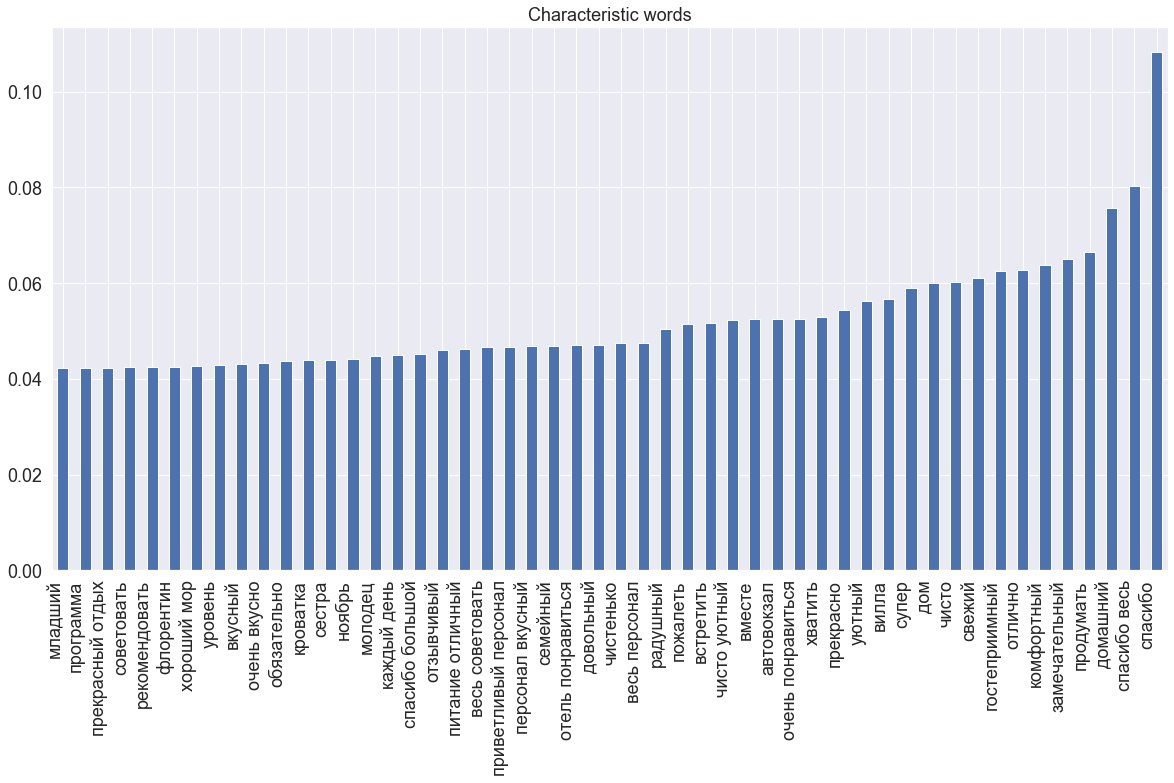

In [30]:
# Слова, характерные для положительных отзывов

UBK5_words=plot_positive_words(LogRegCV[2].coef_[2], TF_IDF[2].get_feature_names(), n_top_features=50)

In [31]:
UBK5_words.to_csv("UBK5.csv",index=True, index_label="words")

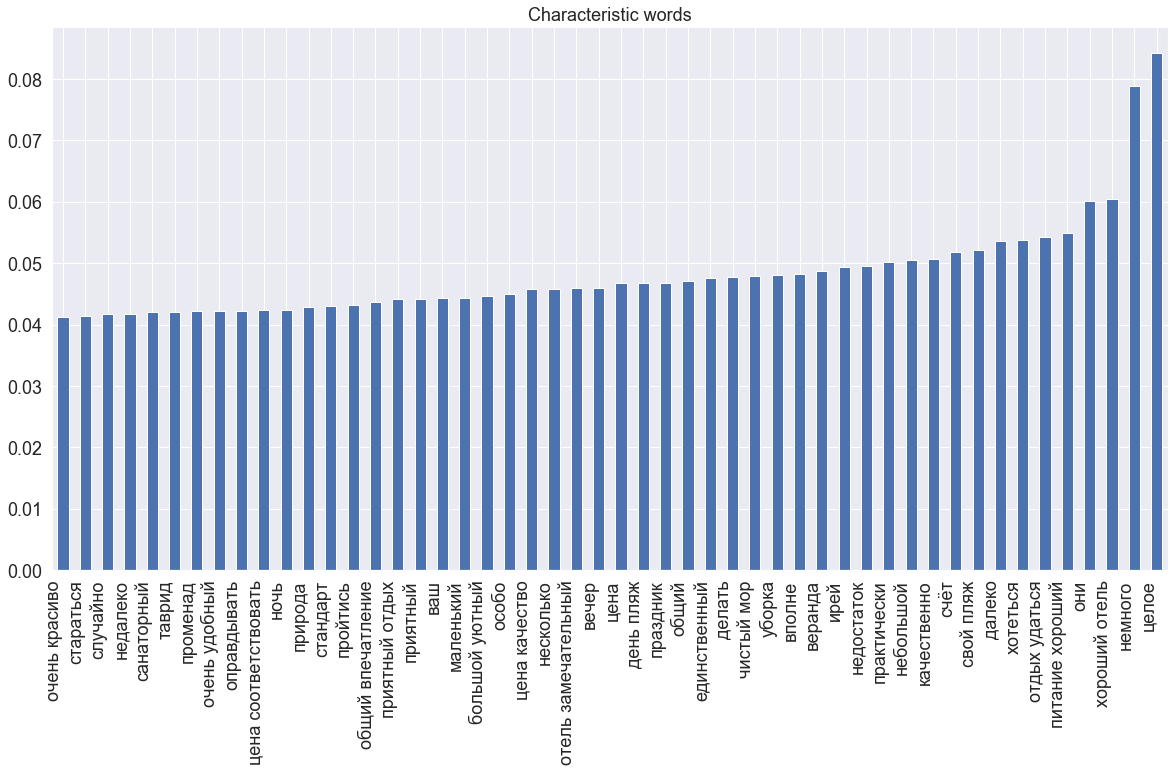

In [32]:
UBK4_words=plot_positive_words(LogRegCV[2].coef_[1], TF_IDF[2].get_feature_names(), n_top_features=50)
UBK4_words.to_csv("UBK4.csv",index=True, index_label="words")

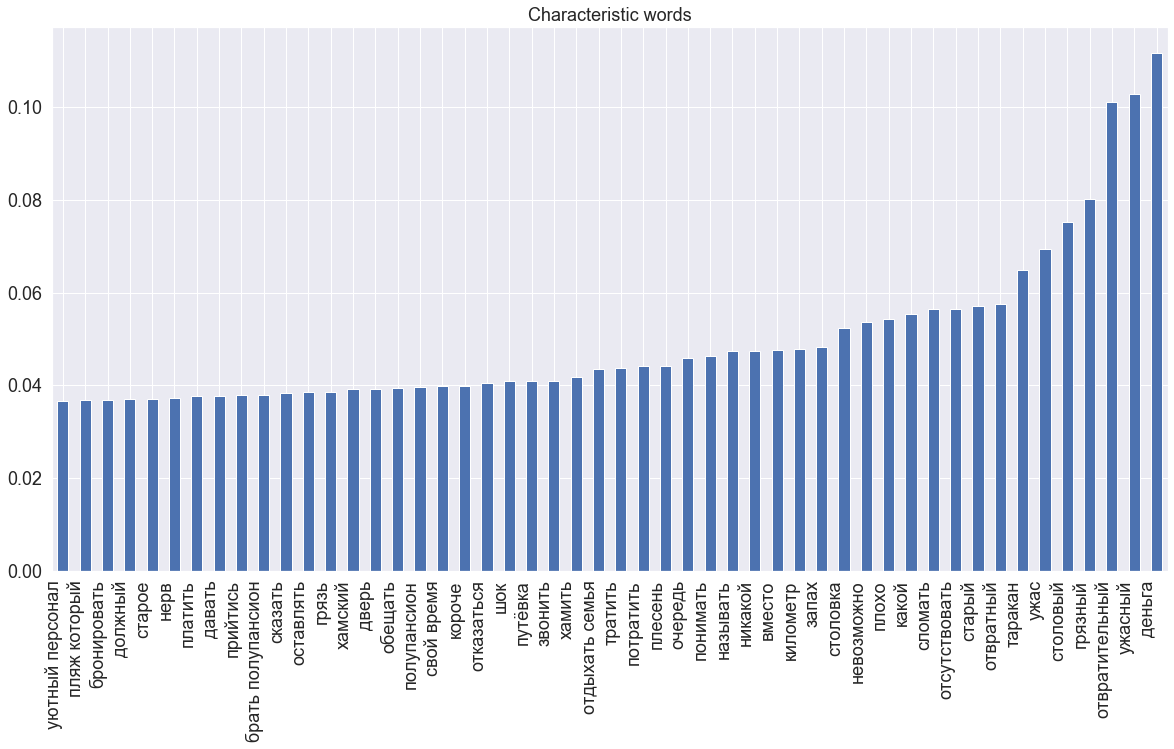

In [33]:
UBK3_words=plot_positive_words(LogRegCV[2].coef_[0], TF_IDF[2].get_feature_names(), n_top_features=50)
UBK3_words.to_csv("UBK3.csv",index=True, index_label="words")

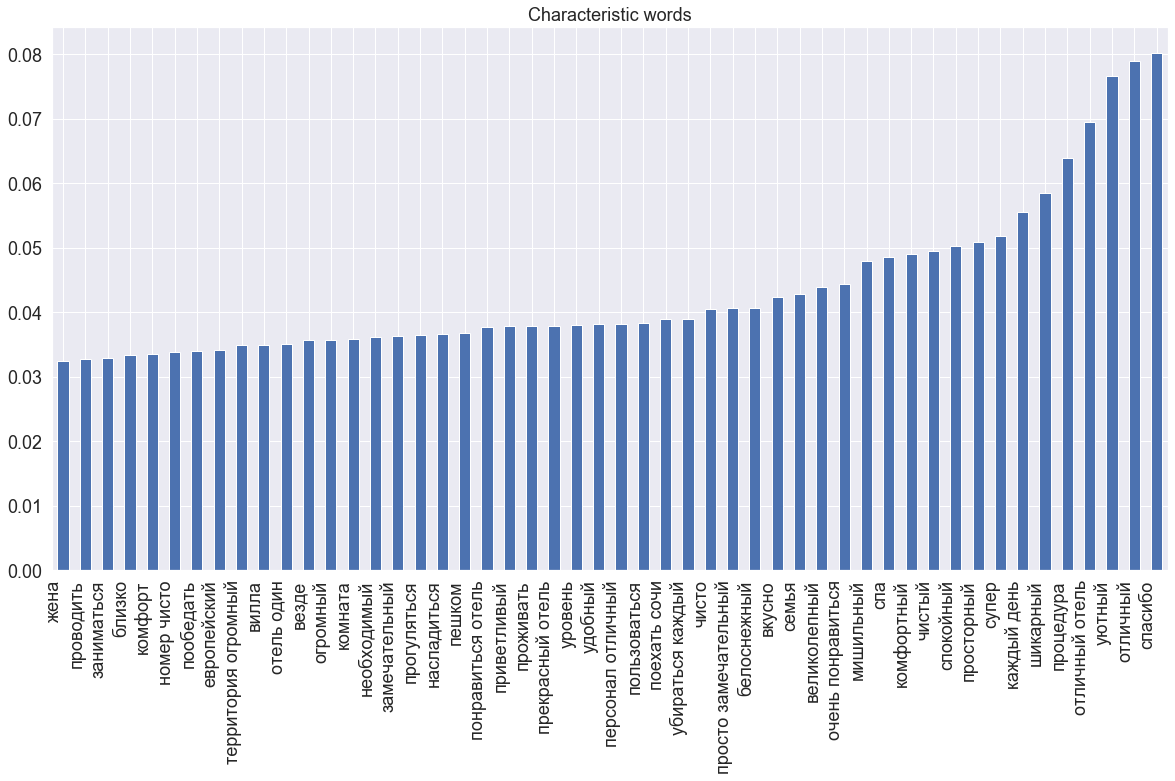

In [34]:
Sochi5_words=plot_positive_words(LogRegCV[1].coef_[2], TF_IDF[1].get_feature_names(), n_top_features=50)
Sochi5_words.to_csv("Sochi5.csv",index=True, index_label="words")

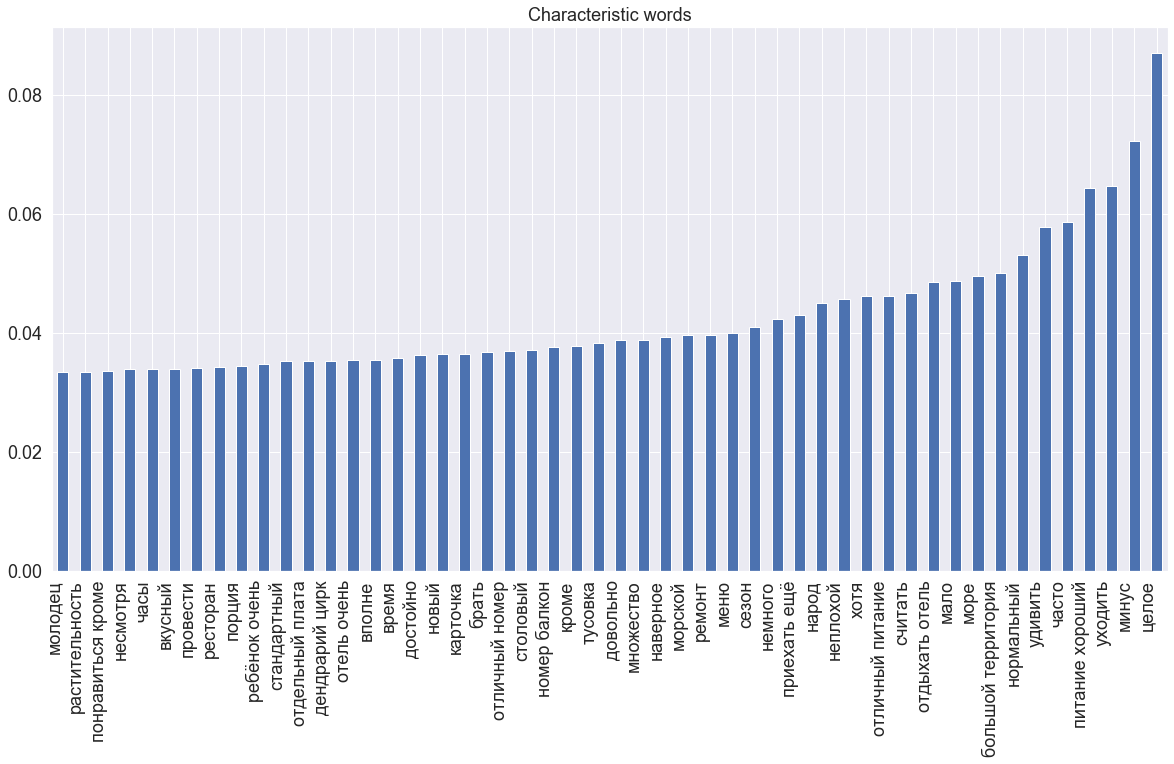

In [35]:
Sochi4_words=plot_positive_words(LogRegCV[1].coef_[1], TF_IDF[1].get_feature_names(), n_top_features=50)
Sochi4_words.to_csv("Sochi4.csv",index=True, index_label="words")

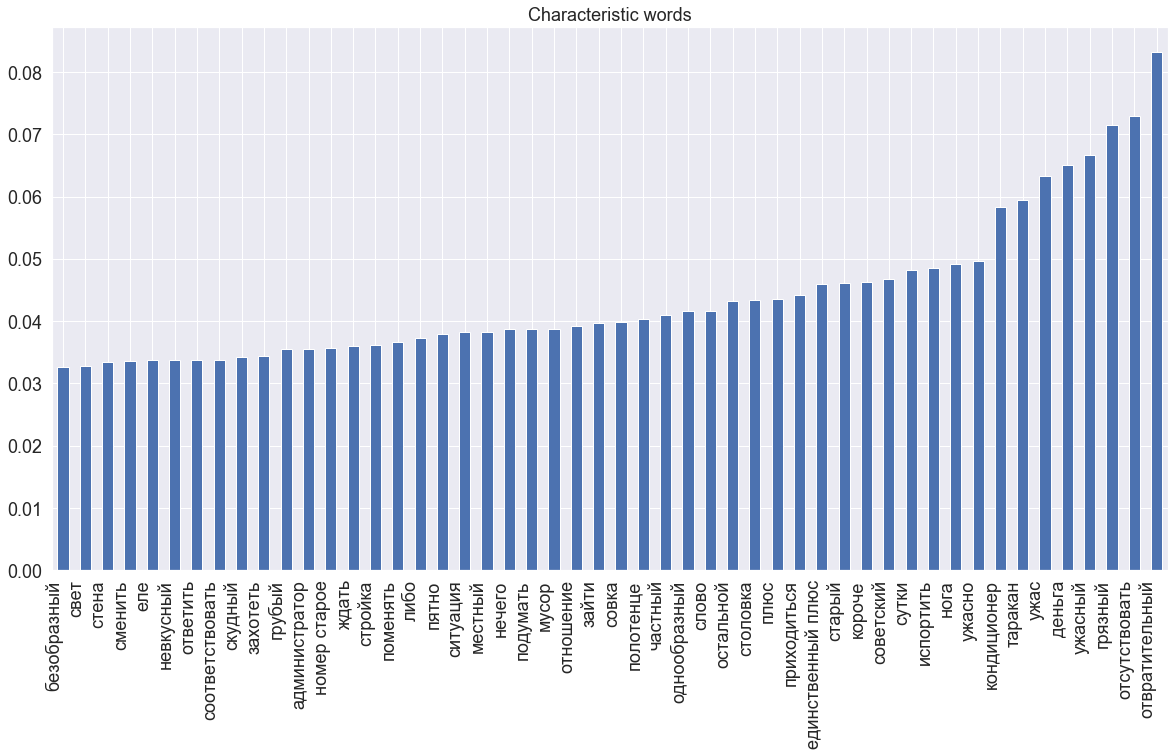

In [36]:
Sochi3_words=plot_positive_words(LogRegCV[1].coef_[0], TF_IDF[1].get_feature_names(), n_top_features=50)
Sochi3_words.to_csv("Sochi3.csv",index=True, index_label="words")

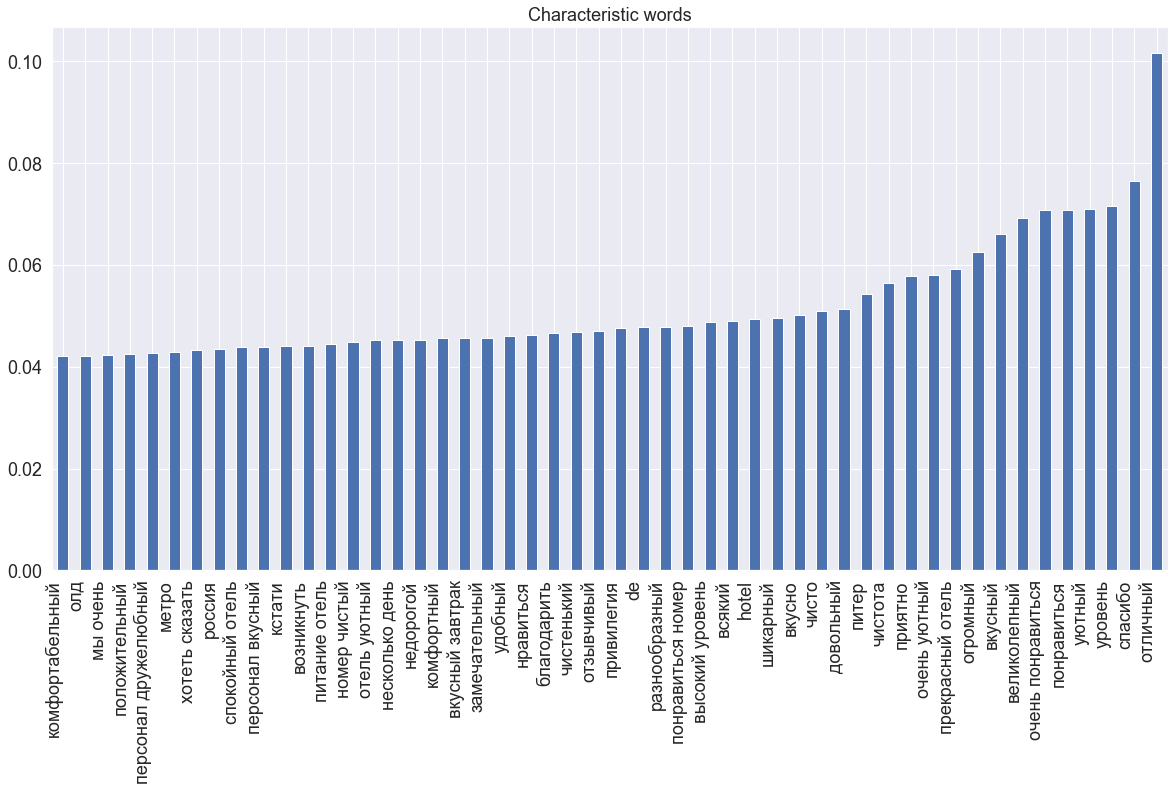

In [37]:
SPb5_words=plot_positive_words(LogRegCV[0].coef_[2], TF_IDF[0].get_feature_names(), n_top_features=50)
SPb5_words.to_csv("SPb5.csv",index=True, index_label="words")

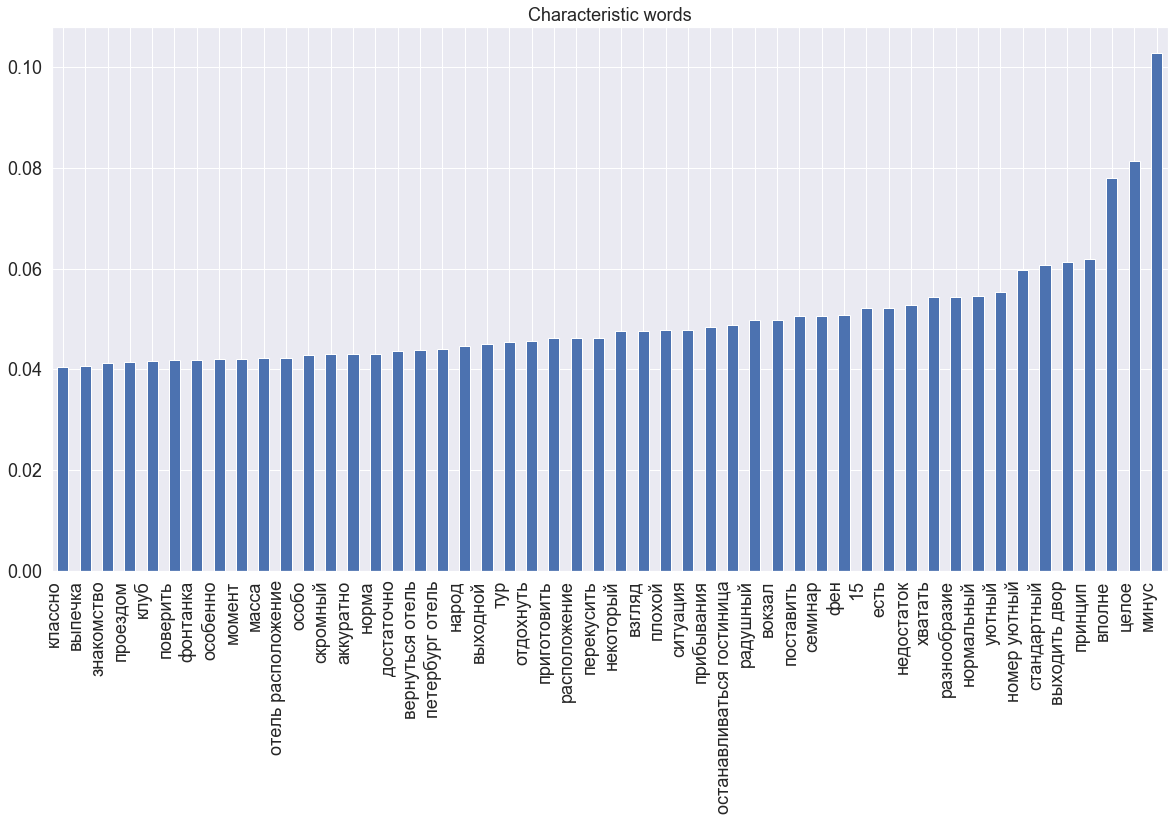

In [38]:
SPb4_words=plot_positive_words(LogRegCV[0].coef_[1], TF_IDF[0].get_feature_names(), n_top_features=50)
SPb4_words.to_csv("SPb4.csv",index=True, index_label="words")

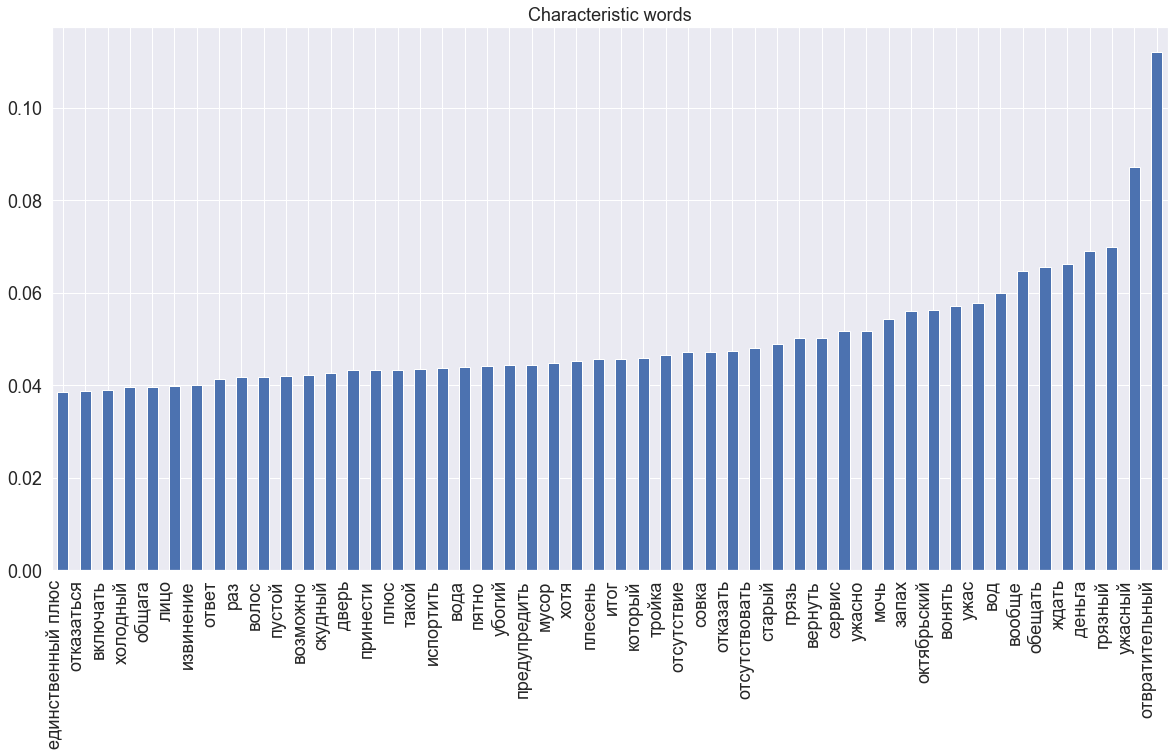

In [39]:
SPb3_words=plot_positive_words(LogRegCV[0].coef_[0], TF_IDF[0].get_feature_names(), n_top_features=50)
SPb3_words.to_csv("SPb3.csv",index=True, index_label="words")